# Определение перспективного тарифа для телеком компании

В моём распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

Тарифа у нас два:
1. Тариф «Смарт»  
   - Ежемесячная плата: 550 рублей
   - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
   - Стоимость услуг сверх тарифного пакета:
     * минута разговора: 3 рубля
     * сообщение: 3 рубля
     * 1 Гб интернет-трафика: 200 рублей  

2. Тариф «Ультра»
   - Ежемесячная плата: 1950 рублей
   - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
   - Стоимость услуг сверх тарифного пакета:
     * минута разговора: 1 рубль
     * сообщение: 1 рубль
     * 1 Гб интернет-трафика: 150 рублей

**Важное замечание**: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.  

У нас 5 отдельных таблиц: **звонки (calls)**, **сообщения (messages)**, **интернет (internet)**, **тарифы (tariffs)**, **пользователи (users)**.

В таблице звонков следующие данные:
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

В таблице пользователей:
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом
* city — город проживания пользователя
* tariff — название тарифного плана

В таблице сообщений:
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение
    
В таблице тарифов:
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
    
В таблице интернета:
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

### Задачи:
1. Посчитать для каждого пользователя:
   * количество сделанных звонков и израсходованных минут разговора по месяцам;
   * количество отправленных сообщений по месяцам;
   * объем израсходованного интернет-трафика по месяцам;
   * помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
2. Описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение.
3. Проверить гипотезы:
   * средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
   * средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
Пороговое значение alpha зададим самостоятельно.
4. Решить, какой тариф лучше.

## Описание данных

Импортруем нужные нам для работы библиотеки и прочитаем файлы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy.stats import levene
from scipy import stats as st


users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv')

### Таблица с пользователями

In [ ]:
users.head(20)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [ ]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Минимальный и максимальный возвраст выглядят адекватно.  
Есть пропуски в датах прекращения использования, появились у тех, кто ещё пользуется услугами провайдера.  
Столбцы с датами имеют неверный формат, их нужно будет перевести

### Таблица со звонками

In [ ]:
calls.head(20)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [ ]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Дата в этой таблице тоже неверного формата, а звонки со значением 0.00 могут быть или пропущенными, или отбитыми

### Таблица с сообщениями

In [ ]:
messages.head(20)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [ ]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Снова дата в формате 'object'.

### Таблица с тарифами

In [ ]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Здесь всё хорошо

### Таблица с интернетом

In [ ]:
internet.head(20)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [ ]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Cтранный столбец 'Unnamed: 0', в нём дублируются индексы. Я думаю, будет правильно его удалить.  

## Обработка и  подготовка данных

**Пользователи**

Пропущенные значения трогать в таблице users не будем, они не помешают нашему исследования
Переведём даты в 'datetime'.

In [ ]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


**Звонки**

Переводим даты в 'datetime'. Также для исследования нам будет нужны месяцы совершённых звонков. Выведем их в отдельный столбец.  
Также переведем минуты в целочисленный формат с округлением в большую сторону.

In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [ ]:
calls['month'] = calls['call_date'].dt.month

In [ ]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls.head(10)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


Теперь поближе посмотрим на нулевые звонки

In [ ]:
len(calls.query('duration == 0.0'))

39613

Почти 40000 значений — это почти 20 процентов данных. Нулями обозначены пропущенные звонки, поэтому их не будем удалять.

**Сообщения**

Переводим дату в формат datetime и сделаем столбец с месяцем как для звонков

In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [ ]:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


**Интернет**

Переводим дату в формат времени.
Добавим столбец с месяцем и удалим странный столбец, который дублирует индексы

In [ ]:
internet.head(20)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [ ]:
#internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону, поэтому мегабайты оставим пока как есть, а потом сложим все сессии за месяц и посмотрим, сколько получилось


In [ ]:
internet['month'] = internet['session_date'].dt.month

In [ ]:
del internet['Unnamed: 0']

internet.head(10)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
5,1000_5,399.97,2018-10-02,1000,10
6,1000_6,540.08,2018-09-07,1000,9
7,1000_7,415.70,2018-07-11,1000,7
8,1000_8,505.40,2018-10-08,1000,10
9,1000_9,345.54,2018-09-03,1000,9


**Вывод**

1. Перевели все даты в формат 'datetime'.
2. Добавили в таблицы со звонками, сообщениями и интернетом месяцы, они нам потом понадобятся.
3. Округлили звонки и мегабайты до целых значений в большую сторону.
4. Удалили странный столбец Unnamed: 0, который дублировал индексы.

### Подготовка данных

**Задачи**

1. Посчитать количество сделанных звонков и израсходованных минут разговора по месяцам;
2. Посчитать количество отправленных сообщений по месяцам;
3. Посчитать объем израсходованного интернет-трафика по месяцам;
4. Посчитать помесячную выручку с каждого пользователя.



**Количество сделанных звонков и израсходованных минут разговора по месяцам**

Делаем новую табличку user_calls, где посчитаем количество звонков и сколько всего минут каждый пользователь наговорил в месяц.

In [ ]:
user_calls = calls.groupby(['user_id', 'month']).agg({'duration':'sum', 'id':'count'}).reset_index()
user_calls = user_calls.rename(columns={'duration':'month_calls_duration','id':'calls_total_month'}) #переименуем столбцы, чтобы к ним было удобнее обращаться


user_calls.head(10)

,user_id,month,month_calls_duration,calls_total_month
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
5,1000,10,350,57
6,1000,11,338,43
7,1000,12,333,46
8,1001,11,430,59
9,1001,12,414,63


**Количество отправленных сообщений по месяцам**

Таким же образом делаем табличку user_messages с количеством сообщений, отправленных за месяц

In [ ]:
user_messages = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
user_messages = user_messages.rename(columns={'id':'sms_total_month'})

user_messages.head(10)

,user_id,month,sms_total_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


<a name="1"></a>

**Объём израсходованного интернет-трафика по месяцам**

In [ ]:
user_internet = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()
user_internet = user_internet.rename(columns={'mb_used':'mb_total_month'})

user_internet.head(10)

,user_id,month,mb_total_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


<a name="2"></a>

Теперь переведём количество мегабайт в гигабайты в соответствии с условием:  общая сумма за месяц округляется в бо́льшую сторону.
Также переведем включённое количество в тариф мегабайт в гб, это нам нужно будет при подсчёте выручки дальше

In [ ]:
user_internet['gb_total_month'] = np.ceil(user_internet['mb_total_month'] / 1024)

user_internet

,user_id,month,mb_total_month,gb_total_month
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0
...,...,...,...,...
3198,1498,10,20579.36,21.0
3199,1499,9,1845.75,2.0
3200,1499,10,17788.51,18.0
3201,1499,11,17963.31,18.0


In [ ]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


**Помесячная выручка с каждого пользователя**

Для того, чтобы вычислить помесячную выручку с каждого пользователя, нужно сначала объединить таблицы. Объединять будем по месяцу и id пользователя.

Сначала объединяем звонки с сообщениями.


In [ ]:
full_data = user_calls.merge(user_messages, on=['user_id','month'], how='outer')

full_data.head(10)

,user_id,month,month_calls_duration,calls_total_month,sms_total_month
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0
5,1000,10,350.0,57.0,73.0
6,1000,11,338.0,43.0,58.0
7,1000,12,333.0,46.0,70.0
8,1001,11,430.0,59.0,NaN
9,1001,12,414.0,63.0,NaN


Теперь добавляем интернет

In [ ]:
full_data = full_data.merge(user_internet, on=['user_id','month'], how = 'outer')
full_data.head(10)

,user_id,month,month_calls_duration,calls_total_month,sms_total_month,mb_total_month,gb_total_month
0,1000,5,159.0,22.0,22.0,2253.49,3.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0
5,1000,10,350.0,57.0,73.0,14702.49,15.0
6,1000,11,338.0,43.0,58.0,14756.47,15.0
7,1000,12,333.0,46.0,70.0,9817.61,10.0
8,1001,11,430.0,59.0,NaN,18429.34,18.0
9,1001,12,414.0,63.0,NaN,14036.66,14.0


И теперь информацию с пользователями по ID и по тарифам

In [ ]:
full_data = full_data.merge(users, on='user_id', how='left')
full_data.head(10)

,user_id,month,month_calls_duration,calls_total_month,sms_total_month,mb_total_month,gb_total_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,350.0,57.0,73.0,14702.49,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,338.0,43.0,58.0,14756.47,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,333.0,46.0,70.0,9817.61,10.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,430.0,59.0,NaN,18429.34,18.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,414.0,63.0,NaN,14036.66,14.0,41,NaT,Москва,Иван,Ежов,2018-11-01,smart


In [ ]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})
full_data = full_data.merge(tariffs, on='tariff', how='left')

full_data.head(10)

,user_id,month,month_calls_duration,calls_total_month,sms_total_month,mb_total_month,gb_total_month,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
5,1000,10,350.0,57.0,73.0,14702.49,15.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
6,1000,11,338.0,43.0,58.0,14756.47,15.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
7,1000,12,333.0,46.0,70.0,9817.61,10.0,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
8,1001,11,430.0,59.0,NaN,18429.34,18.0,41,NaT,Москва,...,2018-11-01,smart,50,15360,500,550,200,3,3,15.0
9,1001,12,414.0,63.0,NaN,14036.66,14.0,41,NaT,Москва,...,2018-11-01,smart,50,15360,500,550,200,3,3,15.0


In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   month_calls_duration   3174 non-null   float64       
 3   calls_total_month      3174 non-null   float64       
 4   sms_total_month        2717 non-null   float64       
 5   mb_total_month         3203 non-null   float64       
 6   gb_total_month         3203 non-null   float64       
 7   age                    3214 non-null   int64         
 8   churn_date             187 non-null    datetime64[ns]
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

Все столбцы на месте.
Кстати, можно заметить, что в столбцах mb_total_month, calls_total_month, month_calls_duration, sms_total_month  есть пропущенные значения. Они говорят о том, что пользователи не пользовались в какой-то месяц интернетом, не отправляли смс или не делали звонков. От пропущенных значений избавляться не будем, просто заменим эти пропуски на нули.

In [ ]:
full_data['sms_total_month'] = full_data['sms_total_month'].fillna(0)
full_data['mb_total_month'] = full_data['mb_total_month'].fillna(0)
full_data['month_calls_duration'] = full_data['month_calls_duration'].fillna(0)
full_data['calls_total_month'] = full_data['calls_total_month'].fillna(0)

In [ ]:
full_data.isna().sum()

user_id                     0
month                       0
month_calls_duration        0
calls_total_month           0
sms_total_month             0
mb_total_month              0
gb_total_month             11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
dtype: int64

Напишем функцию, которая будет считать общую выручку (пока без абонентской платы, её добавим потом).   
Выручка = (всего звонков, сообщений, инетрнет трафика — лимиты по тарифу) х значения из тарифного плана + абонентская плата.

* *в тарифном плане у нас указана цена за гигабайт. При переводе мб в гб, нужно не забыть округлить в большую сторону*

In [ ]:
def month_payment_calc(row):
    sms = (row['sms_total_month'] - row['messages_included']) * row['rub_per_message']
    mins = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    gb = np.ceil((row['gb_total_month'] - row['gb_per_month_included']) * row['rub_per_gb'])
    total = 0
    for i in [sms, mins, gb]:
        if i > 0:
            total += i
    return total

Теперь применим функцию к датафрейму

In [ ]:
full_data['month_payment_calc'] = full_data.apply(lambda x: month_payment_calc(x), axis=1)

full_data.head(10)

,user_id,month,month_calls_duration,calls_total_month,sms_total_month,mb_total_month,gb_total_month,age,churn_date,city,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month_payment_calc
0,1000,5,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
5,1000,10,350.0,57.0,73.0,14702.49,15.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
6,1000,11,338.0,43.0,58.0,14756.47,15.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
7,1000,12,333.0,46.0,70.0,9817.61,10.0,52,NaT,Краснодар,...,ultra,1000,30720,3000,1950,150,1,1,30.0,0.0
8,1001,11,430.0,59.0,0.0,18429.34,18.0,41,NaT,Москва,...,smart,50,15360,500,550,200,3,3,15.0,600.0
9,1001,12,414.0,63.0,0.0,14036.66,14.0,41,NaT,Москва,...,smart,50,15360,500,550,200,3,3,15.0,0.0


У некоторых пользователей появились нули — это ок, они просто не вышли за лимиты тарифа.  
  
Теперь можно добавить абоненскую плату

In [ ]:
full_data['total_month_payment'] = full_data['rub_monthly_fee'] + full_data['month_payment_calc']
full_data.head(20)
# full_data.total_month_payment.sum()

,user_id,month,month_calls_duration,calls_total_month,sms_total_month,mb_total_month,gb_total_month,age,churn_date,city,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,month_payment_calc,total_month_payment
0,1000,5,159.0,22.0,22.0,2253.49,3.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
5,1000,10,350.0,57.0,73.0,14702.49,15.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
6,1000,11,338.0,43.0,58.0,14756.47,15.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
7,1000,12,333.0,46.0,70.0,9817.61,10.0,52,NaT,Краснодар,...,1000,30720,3000,1950,150,1,1,30.0,0.0,1950.0
8,1001,11,430.0,59.0,0.0,18429.34,18.0,41,NaT,Москва,...,50,15360,500,550,200,3,3,15.0,600.0,1150.0
9,1001,12,414.0,63.0,0.0,14036.66,14.0,41,NaT,Москва,...,50,15360,500,550,200,3,3,15.0,0.0,550.0


**Вывод**

1. Посчитали количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам,помесячную выручка с каждого пользователя.
2. Объединили полученные данные в одну табличку и посчитали помесячную выручку с каждого клиента.

## Анализ данных

**Задачи**
- Описать поведение клиентов оператора.
- Узнать, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц.
- Посчитать среднее количество, дисперсию и стандартное отклонение.
- Построить гистограммы и описать распределения.

**Тарифы**

In [ ]:
full_data['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

У нас 2229 клиентов, которые пользуются смартом и 985 клиентов, которые выбирают тариф подороже.
Построим гистограммы, на которых увидим, как распределяются траты по каждому тарифу и посмотрим на среднее, дисперсию и стандартное отклонение

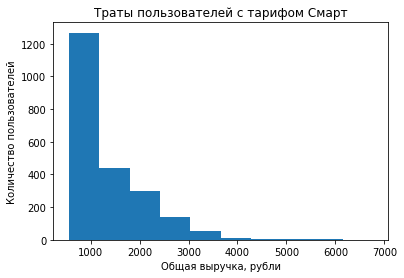

In [ ]:
full_data[full_data['tariff'] == 'smart']['total_month_payment'].plot(kind='hist', bins=10)
plt.title('Траты пользователей с тарифом Смарт')
plt.xlabel('Общая выручка, рубли')
plt.ylabel('Количество пользователей')
plt.show()

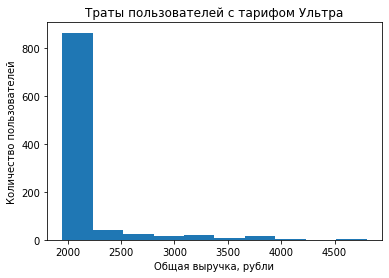

In [ ]:
full_data[full_data['tariff'] == 'ultra']['total_month_payment'].plot(kind='hist', bins=10)
plt.title('Траты пользователей с тарифом Ультра')
plt.xlabel('Общая выручка, рубли')
plt.ylabel('Количество пользователей')
plt.show()

In [ ]:
full_data[full_data['tariff'] == 'smart']['total_month_payment'].sum()

2875351.0

In [ ]:
full_data[full_data['tariff'] == 'ultra']['total_month_payment'].sum()

2039100.0

In [ ]:
full_data.groupby('tariff').agg({'total_month_payment':['mean','var','std']}).style.format("{:.2f}")

Клиенты с тарифом Ультра в основном платят только по тарифу. Только у небольшого количества людей получается перерасход. А клиенты с тарифом Смарт чаще платят сверх тарифа — им не хватает того, что включено.
Кроме этого, пользователи тарифа Смарт из-за перерасходов в конечном итоге приносят на 715 тысяч в казну больше

**Звонки**

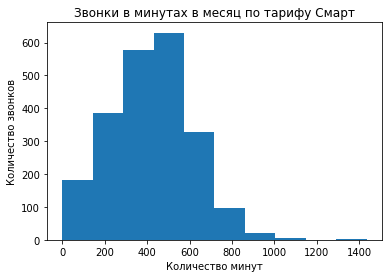

In [ ]:
full_data[full_data['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Звонки в минутах в месяц по тарифу Смарт')
plt.xlabel('Количество минут')
plt.ylabel('Количество звонков')
plt.show()

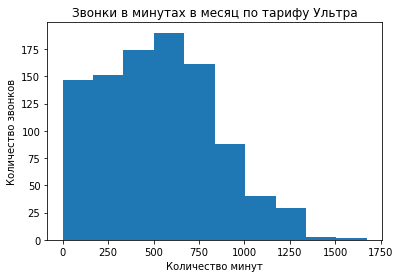

In [ ]:
full_data[full_data['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Звонки в минутах в месяц по тарифу Ультра')
plt.xlabel('Количество минут')
plt.ylabel('Количество звонков')
plt.show()

In [ ]:
full_data.groupby('tariff').agg({'month_calls_duration':['mean','var','std']}).style.format("{:.2f}")

В среднем клиенты по тарифу Смарт разговаривают 420-450 минут, а по тарифу Ультра — на 100 минут больше.

Те, кто используют тариф Смарт, стараются не вылезать за рамки тарифа. А у пользователей тарифа Ультра ещё остаются минуты в запасе. Было бы классно, если бы их можно было продавать на внутренней бирже или обменивать на смс или интернет.

**Сообщения**

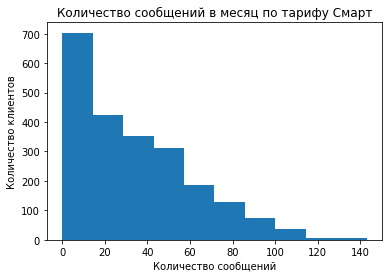

In [ ]:
full_data[full_data['tariff'] == 'smart']['sms_total_month'].plot(kind='hist', bins=10)
plt.title('Количество сообщений в месяц по тарифу Смарт')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество клиентов')
plt.show()

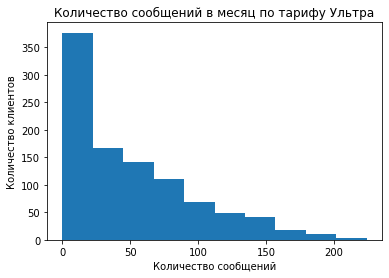

In [ ]:
full_data[full_data['tariff'] == 'ultra']['sms_total_month'].plot(kind='hist', bins=10)
plt.title('Количество сообщений в месяц по тарифу Ультра')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество клиентов')
plt.show()

In [ ]:
full_data.groupby('tariff').agg({'sms_total_month':['mean','var','std']}).style.format("{:.2f}")

Смсками практически никто не пользуется, среднее и в тарифе Смарт, и в тарифе Ультра — меньше 50 сообщений в месяц.
Возможно, клиенты просто пользуются месенджерами, поэтому потребности в смс сообщениях нет.
Но если посмотреть на гистограмму сообщений по тарифу Смарт, то видно, что есть пользователи, которым включенное количество смс всё-таки не хватает и им приходится переплачивать.

У пользователей тарифа Ультра остается очень много смсок, за которые уплачено :(

**Интернет**

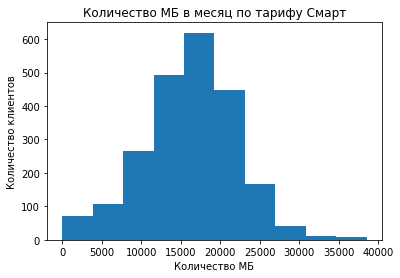

In [ ]:
full_data[full_data['tariff'] == 'smart']['mb_total_month'].plot(kind='hist', bins=10)
plt.title('Количество МБ в месяц по тарифу Смарт')
plt.xlabel('Количество МБ')
plt.ylabel('Количество клиентов')
plt.show()

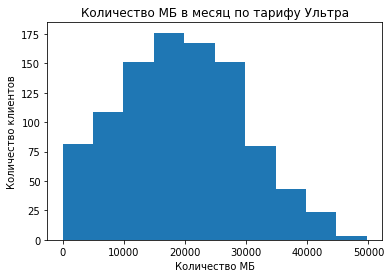

In [ ]:
full_data[full_data['tariff'] == 'ultra']['mb_total_month'].plot(kind='hist', bins=10)
plt.title('Количество МБ в месяц по тарифу Ультра')
plt.xlabel('Количество МБ')
plt.ylabel('Количество клиентов')
plt.show()

In [ ]:
full_data.groupby('tariff').agg({'mb_total_month':['mean','var','std']}).style.format("{:.2f}")

In [ ]:
16208.87 + 3 * 5870.48

33820.31

In [ ]:
19469.31 + 3 * 10087.20

49730.91

Интернетом в обоих тарифах пользуются почти одинаково. Однако пользователям тарифа Смарт чаще не хватает включённого интернета, поэтому им приходится докупать мегабайты, а у пользователей тарифа Ультра снова остаётся запас.
Есть пользователи тарифа Смарт, которые тратят в два раза больше мегабайт, чем заложено в тариф

**Вывод**

Что интернетом, что звонками и сообщениями пользователи пользуются прммерно одинаково в каждом из тарифов. Однако пользователям Смарта чаще не хватает заложенного в тариф в отличие от пользователей тарифа Ультра — у них, наоборот, часть пакета остаётся неизрасходованной.


Пользователям тарифа «Смарт» в среднем требуется 417 минут разговора, 33 смски и чуть больше 15 гб интернета.Пользователи используют его по максимуму
А пользователям тарифа «Ультра» — 526 минут разговора, 49 смсок и 19 гб интернета. Это гораздо меньше, чем заложено в тариф, поэтому его покупка для пользователя — деньги на ветер (остатки не переносятся на следующий месяц).


По выручке: выручка абонентов Уьтра в подавляющем большинстве случаев ограничивается абонплатой(1950р), а абоненты тарифа Смарт, наоборот, чаще платят сверх абонплаты 1231 - 550 = 681 рубль (это как две абон платы и ещё 23% сверху) в основном за счёт мобильного интернета, но это все равно меньше, чем в тарифе Ультра. Однако пользователей тарифа Смарт в два раза больше, чем пользователей тарифа Ультра, поэтому по общей прибыли Смарт приносит на 715 тысяч денег больше.

Если нашей задачей в дальнейшем будет увеличение количества выручки за счёт увеличения количества пользователей тарифа Ультра, то тогда компании нужно немного ухудшить условия тарифа Смарт, а именно уменьшить количество включённых мегабайт, например до 10.



### Проверка гипотез

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Пороговое значение alpha зададим самостоятельно.

H₀ всегда формулируется так, чтобы использовать знак равенства, а исходя из H₀ формулируется альтернативная гипотеза H₁.    

Поэтому по первому пункту:  
H₀: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.  
H₁: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.  

По второму пункту:   
H₀: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
H₁: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  

alpha = 0.05

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<b> Комментарий ревьюера</b>
    
Формулировки правильные
    
</div>

**Первая  гипотеза**

H₀: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается.  
H₁: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Прежде, чем приступать к исследованию, нужно избавиться от выбросов, напишем функцию для определения границ интервалов.

In [ ]:
def whiskers(data, column):
    stat = data[column].describe()
    iqr = stat[6] - stat[4]
    left_whisker = round(stat[4] - 1.5 * iqr, 2)
    right_whisker = round(stat[6] + 1.5 * iqr, 2)
    if left_whisker < stat[3]: left_whisker = stat[3]
    if right_whisker > stat[7]: right_whisker = stat[7]
    return [left_whisker, right_whisker]

Берем две выборки: одна — пользователи с тарифом Смарт, вторая — пользователи с тарифом Ультра. Они независимые, поэтому воспользуемся ttest_ind.

In [ ]:
ultra = full_data[full_data['tariff'] == 'ultra']
smart = full_data[full_data['tariff'] == 'smart']

In [ ]:
whiskers(ultra, 'total_month_payment')

[1950.0, 1950.0]

Из гистограммы распределения видно, что очень большой пик на этом значении, поэтому границы размаха получились одним числом. Увеличу правую границу до 2500, по гистограмме видно, что немало людей немного выходят за границы тарифа и доплачивают.

In [ ]:
whiskers(smart, 'total_month_payment')

[550.0, 3550.0]

Формируем выборки

In [ ]:
full_data['total_month_payment'] = full_data['total_month_payment'].astype(int)

In [ ]:
smart_payment = full_data[(full_data['tariff'] == 'smart') & (full_data['total_month_payment'] >= 550) & (full_data['total_month_payment'] <= 3348)]['total_month_payment']

In [ ]:
ultra_payment = full_data[(full_data['tariff'] == 'ultra') & (full_data['total_month_payment'] >= 1950) &(full_data['total_month_payment'] <= 2500)]['total_month_payment']

Произведём проверку равенства дисперсий выборок, чтобы понять с каким параметром equal_var использовать метод проверки ttest_ind. Воспользуемся стат. тестом Левене

In [ ]:
alpha = 0.05

results = st.levene(smart_payment, ultra_payment)

results.pvalue

4.183730519488069e-222

Полученное число меньше 0.05, значит, дисперсии не равны и мы возьмём equal_var=False

In [ ]:
alpha = .05

results = st.ttest_ind(smart_payment, ultra_payment, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Гипотезу отвергаем, средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [ ]:
print('Средняя выручка по пользователям тарифа "Смарт" - {:.2f}'.format(smart_payment.mean()))
print('Средняя выручка по пользователям тарифа "Ультра" - {}'.format(ultra_payment.mean()))

Средняя выручка по пользователям тарифа "Смарт" - 1228.13
Средняя выручка по пользователям тарифа "Ультра" - 1967.960088691796


**Вторая гипотеза**

H₀: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.  
H₁: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [ ]:
moscow = full_data[full_data['city'] == 'Москва']
regions = full_data[full_data['city'] != 'Москва']

In [ ]:
whiskers(moscow, 'total_month_payment')

[550.0, 3704.25]

In [ ]:
whiskers(regions, 'total_month_payment')

[550.0, 3750.0]

In [ ]:
moscow_payment = full_data[(full_data['city'] == 'Москва') & (full_data['total_month_payment'] >= 550) & (full_data['total_month_payment'] <= 3775.5)]['total_month_payment']

regions_payment = full_data[(full_data['city'] != 'Москва') & (full_data['total_month_payment'] >= 550) & (full_data['total_month_payment'] <= 3840)]['total_month_payment']

Проверка равенствва дисперсий выборок

In [ ]:
alpha = 0.05

results = st.levene(moscow_payment, regions_payment)

results.pvalue

0.02807666862289748

Полученное число меньше 0.05, значит, дисперсии не равны и мы возьмём equal_var=False


In [ ]:
alpha = .05

results = st.ttest_ind(moscow_payment, regions_payment, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.2710779369210562
Не получилось отвергнуть нулевую гипотезу


Гипотезу отвергнуть не получилось. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

In [ ]:
print('Средняя выручка по пользователю в месяц в Москве: {:.2f}'.format(moscow_payment.mean()))
print('Средняя выручка по пользователю в месяц в регионах: {:.2f}'.format(regions_payment.mean()))

Средняя выручка по пользователю в месяц в Москве: 1528.26
Средняя выручка по пользователю в месяц в регионах: 1492.32


**Вывод**

Первую гипотезу мы отвергли, а вторую отвергнуть не получилось. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, но средняя выручка пользователей из Москвы поти не отличается от выручки пользователей из других регионов.

## Общий вывод

**Обработка:**
1. В сырых данных было большое количество звонков по «0» минут — почти 20% от общих данных. Это пропущенные звонки, от них мы не стали избавляться.
2. Также в таблице по пользователям отсутствует 92% значений о клиентах, которые прекратили пользоваться тарифом — это пользователи, которые продолжают пользоваться услугами. Избавляться от таких пропусков считаю неправильным, поэто оставила их как есть.
3. Все строки с датами в формате 'object' перевели в datetime.  
4. В таблице с информацией по интернету появился странный столбец Unnamed: 0, он полностью копировал индексы, поэтому мы от него избавились.
5. Дробные минуты и мегабайты округлила до целых в большую сторону.  

**Выводы по исследованию:**
1. Пользователи тарифа «Смарт» по максимуму используют возможности тарифа, поэтому у них не всегда получается не превысить заложенное.  
Пользователи «Ультра», наоборот, не используют все возиожности своего тарифного плана.
2. Как пользователи «Смарта», так и пользователи «Ультры» почти не шлют смс. Вероятно, общаются в мессенжерах, поэтому, что у тех, что у других пользователей довольно большие траты трафика: в среднем 15-20 Гб в месяц.
Однако, если пользователи «Смарт» тратят почти все смс, что заложены, то у пользователей «Ультры» в конце месяца остаётся достаточно много неиспользованных сообщений.
3. Выручка почти одинаковая и в регионах, и в Москве. Люди общаются примерно одинаково везде и уровень жизни на выручку не влияет.
4. С перерасходом «Смарт» остаётся дешевле «Ультры», однако пользователей «Смарта» больше пользователей «Ультры» чем в 2 раза, поэтому выручка превышает выручку с «Ультры» на 715 тысяч денег

Сейчас самый перспективный тариф — это «Смарт» как для пользователя, так и для компании, поэтому будет выгоднее всего вложиться в рекламную компанию именно его.
  
Со стороны пользователя он используется максимально эффективно, почти все заложенные ресурсы используются по максимуму. Единственное, не хватает интернета, поэтому пользователю приходится его докупать. Но это всё равно выходит дешевле, чем в тарифе «Ультра». 1231 против 1980 рублей.
  
Со стороны компании этот тариф прибыльнее: приносит в целом на 715 тысяч рублей больше из-за того, что пользователей тарифа более, чем в два раза больше пользователей тарифа «Ультра».

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<b> Комментарий ревьюера 2</b>
    
Хорошо, а мой аргумент в том, что каждый новый пользователь ультра приносит нам около 2060 рублей, а смарт - только около 1231 (цифры пока неточны, но сути не меняет). НАрисовал тебе внизу график выручки.
    
К тому же ультра гораздо более предсказуемы, тк их 5% - 95% квантили имеют меньший разброс. Поэтому выручку от них легче предсказать, что будет превлекательнее для бизнеса.
Может быть лучше привлечь ультра и получить с них больше денег?

Как будешь парировать?
 (напомню, что правильного ответа нет)
</div>

In [ ]:
#ревьюер_код_ит
ultra = full_data[full_data['tariff'] == 'ultra']
smart = full_data[full_data['tariff'] == 'smart']

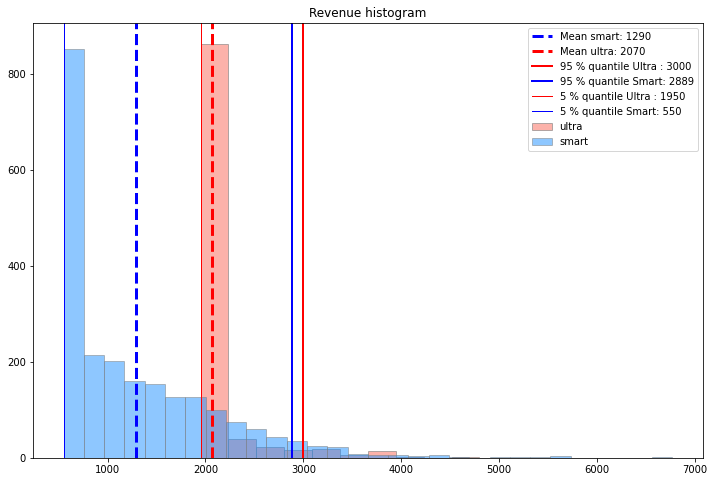

In [ ]:
#ревьюер_код_ит
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.hist(ultra.total_month_payment, bins=10, color='salmon', edgecolor='grey', alpha=0.6, label = 'ultra', density = False)
plt.hist(smart.total_month_payment, bins=30, color='dodgerblue', edgecolor='grey', alpha=0.5,label = 'smart', density = False)

plt.axvline(smart.total_month_payment.mean(), color='blue', linestyle='dashed', linewidth=3
                , label='Mean smart: {:.0f}'.format(smart.total_month_payment.mean()))
plt.axvline(ultra.total_month_payment.mean(), color='r', linestyle='dashed', linewidth=3
            , label='Mean ultra: {:.0f}'.format(ultra.total_month_payment.mean()))
plt.axvline(np.quantile(ultra.total_month_payment, 0.95), color='r', linestyle='solid', linewidth=2,
            label='95 % quantile Ultra : {:.0f}'.format(np.quantile(ultra.total_month_payment, 0.95)))
plt.axvline(np.quantile(smart.total_month_payment, 0.95), color='blue', linestyle='solid', linewidth=2,
            label='95 % quantile Smart: {:.0f}'.format(np.quantile(smart.total_month_payment, 0.95)))
plt.axvline(np.quantile(ultra.total_month_payment, 0.05), color='r', linestyle='solid', linewidth=1,
            label='5 % quantile Ultra : {:.0f}'.format(np.quantile(ultra.total_month_payment, 0.05)))
plt.axvline(np.quantile(smart.total_month_payment, 0.05), color='blue', linestyle='solid', linewidth=1,
            label='5 % quantile Smart: {:.0f}'.format(np.quantile(smart.total_month_payment, 0.05)))
plt.legend()
plt.title('Revenue histogram')
plt.show()

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"></h2>

Я переубедилась и хочу согласиться 😅  
    
Только мне сильно кажется, что часть привлеченных ультр потом поотваливаются на смарт и выйдет в итоге тож на тож из-за того, что мы не переносим остатки на следующий месяц (Как пользователю мне бы смарт был бы выгоднее: в одном месяце переплатила, сколько надо, во втором нет, но все равно какую-то денежку занесла)
    
Наверное это будет не очень выгодно, если стоимость рекламы для привлечения 1 человека с ультрой выйдет дороже смарта. Если у маркетологов уже есть данные, сколько денег мы примерно обычно тратим на всё это дело, то я бы попросила их сначала посмотреть перед тем, как делать окончательный вывод)


</div>

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<b> Комментарий ревьюера 2</b>
    
Вполне справедливо. Открою небольшой секрет, любая реклама этих (российских) мегалайнов заведомо убыточная и никогда себя не окупит. Нагиев стоит дорого)
</div>

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px;border: 1px solid ">
<b> Комментарий ревьюера</b>

В целом все комментарии ок. Мне всё нравится. Удачи в дальнейшем)
</div>